In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import torch
import time
import pickle
import seaborn as sns
import scipy.stats

In [2]:
sys.path.append('/global/u2/v/vboehm/codes/SIG_GIS/')
from sig_gis import *
from sig_gis.GIS import *

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
classes = {2:'GAL', 1:'QSO', 0:'STAR'}

In [5]:
plotpath = '/global/homes/v/vboehm/codes/SDSS_PAE/figures'

In [6]:
RUN             = '1'
EPOCHS          = 40

seeds           = {'1':512, '2':879, '3':9981, '4': 20075, '5': 66, '6': 276, '7': 936664}

conditional     = False
cond_on         = 'type'

root_model_data = '/global/cscratch1/sd/vboehm/Datasets/sdss/by_model/'
root_models     = '/global/cscratch1/sd/vboehm/Models/SDSS_AE/'
root_encoded    = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
root_decoded    = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'


wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000
min_SN          = 50
min_z           = 0.1
max_z           = 0.36
label           = 'galaxies_quasars_bins%d_wl%d-%d'%(fixed_num_bins,wlmin,wlmax)
label_          = label+'_minz%s_maxz%s_minSN%d'%(str(int(min_z*100)).zfill(3),str(int(max_z*100)).zfill(3),min_SN)
label_2         = label_+'_10_fully_connected_mean_div'

if conditional:
    label_2='conditional_%s'%cond_on+label_2
    
upsampling      = 'SMOTE'
fac             = 10

In [48]:
encoded_train, encoded_valid, encoded_test = np.load(os.path.join(root_encoded,'encoded_%s_RUN%s_2.npy'%(label_2, RUN)), allow_pickle=True)
decoded_train,decoded_valid, decoded_test  = np.load(os.path.join(root_decoded,'decoded_%s_RUN%s_2.npy'%(label_2, RUN)), allow_pickle=True)

In [49]:
train,valid,test,le = pickle.load(open(os.path.join(root_model_data,'combined_%s.pkl'%label_),'rb'))

In [50]:
encoded_train.shape

(70311, 10)

In [51]:
train_x = torch.Tensor(np.squeeze(encoded_train)).to(device) 
train_y = torch.Tensor(train['subclass']).to(torch.long).to(device)

valid_x = torch.Tensor(np.squeeze(encoded_valid)).to(device) 
valid_y = torch.Tensor(valid['subclass']).to(torch.long).to(device)

train_x = torch.Tensor(np.squeeze(encoded_train)).to(device) 
train_y = torch.Tensor(train['subclass']).to(torch.long).to(device)

In [88]:
np.unique(train['class'])

array([1, 2])

In [53]:
model = torch.load(os.path.join(root_models,'conditional_SINF_%s_%s_%d_inpainted_denoised'%(label_2,upsampling,fac)))

In [54]:
dens      = model.evaluate_density(train_x,train_y).cpu().numpy()

In [55]:
df        = pd.DataFrame.from_dict(dict((k,train[k]) for k in ('MJD','fiber','plate','subclass') if k in train))
df['logp']= dens
df['mask_fracs'] = np.sum(~train['mask'].astype('bool'),axis=1)/1000
df['z'] = train['z']
noise = np.ma.array(np.squeeze(train['noise']),mask=~np.squeeze(train['mask'].astype('bool')))
df['recon_error'] = np.ma.mean(np.ma.array(np.squeeze(train['spec'])-decoded_train,mask=~np.squeeze(train['mask'].astype('bool')))**2*noise,axis=1)
df['max_recon_error'] = np.ma.max(np.ma.array(np.squeeze(train['spec'])-decoded_train,mask=~np.squeeze(train['mask'].astype('bool')))**2*noise,axis=1)
df = df.reset_index()

In [56]:
import sklearn.linear_model
import sklearn.kernel_ridge
LRl = sklearn.linear_model.LinearRegression()

In [57]:
ind = (df['mask_fracs']>0.02)*(df['logp']>-50)
LRl.fit(df['mask_fracs'][ind,None],df['logp'][ind,None])

/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


LinearRegression()

/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  This is separate from the ipykernel package so we can avoid doing imports until


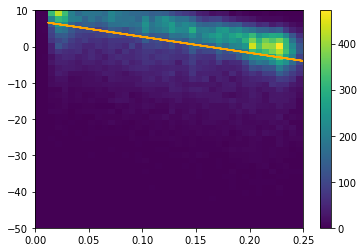

In [58]:
h =plt.hist2d(df['mask_fracs'], df['logp'], range=[[0,0.25],[-50,10]], bins=[40,40])
x= df['mask_fracs']
plt.plot(x, LRl.predict(x[:,None]),color='orange')
plt.colorbar(h[3])

In [59]:
corr, _= scipy.stats.pearsonr(df['mask_fracs'][ind],-df['logp'][ind])
print(corr)
df['logp_corr'] = df['logp']-(LRl.coef_[0]*x+LRl.intercept_[0])
corr, _= scipy.stats.pearsonr(df['mask_fracs'][ind],df['logp_corr'][ind])
print(corr)
corr, _= scipy.stats.pearsonr(df['mask_fracs'][ind],df['z'][ind])
print(corr)
corr, _= scipy.stats.pearsonr(-df['logp'][ind],df['z'][ind])
print(corr)

0.39670244705533664
1.0245710529988017e-15
0.9924303141131868
0.38801127096426624


(array([ 686.,  729.,  726.,  643.,  681.,  792.,  746.,  731.,  563.,
         627.,  600.,  570.,  666.,  672.,  645.,  596.,  549.,  522.,
         567.,  562.,  545.,  509.,  481.,  508.,  564.,  599.,  540.,
         532.,  568.,  577.,  659.,  657.,  586.,  631.,  630.,  622.,
         590.,  658.,  568.,  598.,  640.,  610.,  590.,  685.,  638.,
         652.,  653.,  696.,  695.,  705.,  664.,  643.,  668.,  663.,
         672.,  658.,  649.,  681.,  637.,  637.,  629.,  643.,  659.,
         645.,  657.,  671.,  601.,  630.,  638.,  629.,  656.,  689.,
         592.,  683.,  654.,  747.,  776.,  747.,  726.,  746.,  766.,
         800.,  821.,  896.,  903.,  985.,  952.,  940., 1025.,  981.,
        1055., 1130., 1102., 1014.,  998., 1009., 1052.,  988.,  873.,
         972.]),
 array([0.10000125, 0.10260122, 0.10520118, 0.10780115, 0.11040112,
        0.11300109, 0.11560105, 0.11820102, 0.12080098, 0.12340095,
        0.12600091, 0.12860088, 0.13120085, 0.1338008 , 0.13640077

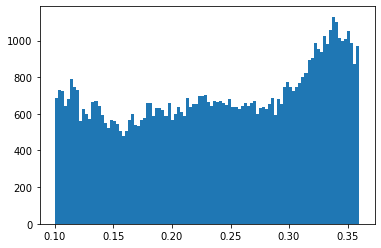

In [60]:
plt.hist(df['z'],bins=100)

Text(0.5, 0, 'mask_fracs')

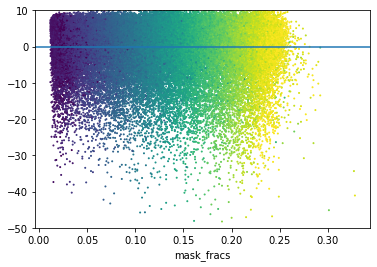

In [61]:
plt.scatter(df['mask_fracs'],df['logp_corr'], s=1, c=df['z'])
plt.axhline(0)
plt.ylim(-50,10)
plt.xlabel('mask_fracs')

Text(0.5, 0, 'mask_fracs')

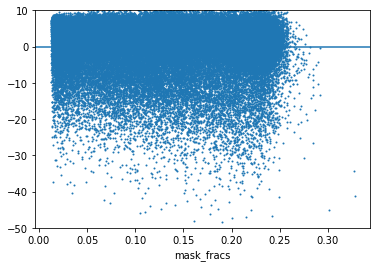

In [62]:
plt.scatter(df['mask_fracs'],df['logp_corr'], s=1)
plt.axhline(0)
plt.ylim(-50,10)
plt.xlabel('mask_fracs')

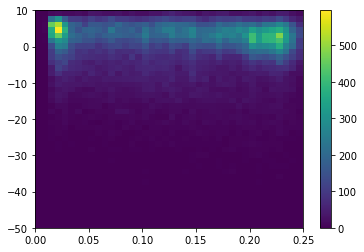

In [63]:
h =plt.hist2d(df['mask_fracs'], df['logp_corr'], range=[[0,0.25],[-50,10]], bins=[40,40])
plt.colorbar()

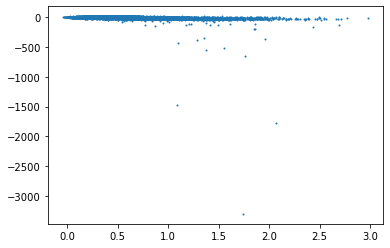

In [64]:
plt.scatter(np.log(df['recon_error']),df['logp'],s=1)

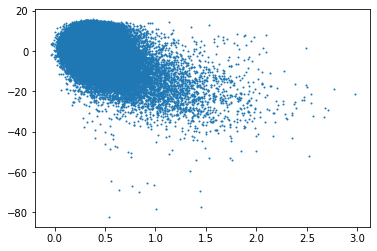

In [65]:
plt.scatter(np.log(df['recon_error'][df['logp']>-100]),df['logp'][df['logp']>-100],s=1)

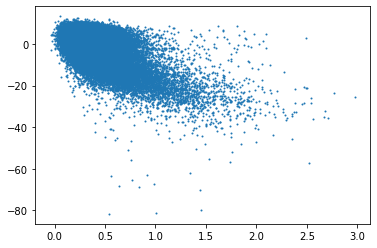

In [66]:
plt.scatter(np.log(df['recon_error'][df['logp_corr']>-100]),df['logp_corr'][df['logp_corr']>-100],s=1)

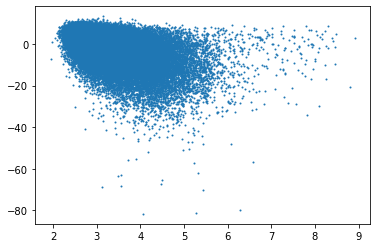

In [67]:
plt.scatter(np.log(df['max_recon_error'][df['logp_corr']>-100]),df['logp_corr'][df['logp_corr']>-100],s=1)

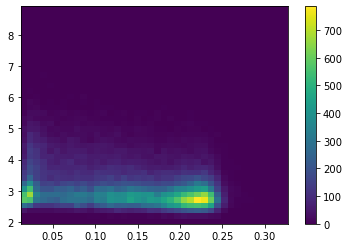

In [68]:
h =plt.hist2d(df['mask_fracs'], np.log(df['max_recon_error']), bins=[40,40])
plt.colorbar()

In [69]:
len(df)

70311

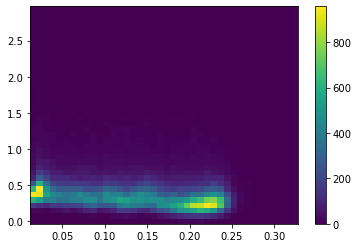

In [70]:
h =plt.hist2d(df['mask_fracs'], np.log(df['recon_error']), bins=[40,40])
plt.colorbar()

In [71]:
scipy.stats.pearsonr(np.log(df['recon_error']),df['logp_corr'])

(-0.29377535761504814, 0.0)

In [72]:
scipy.stats.pearsonr(np.log(df['max_recon_error']),df['logp_corr'])

(-0.22558054472640465, 0.0)

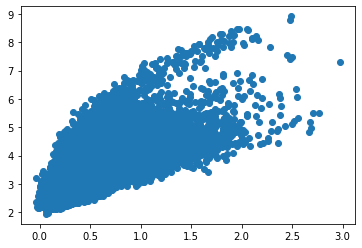

In [73]:
plt.scatter(np.log(df['recon_error']),np.log(df['max_recon_error']))

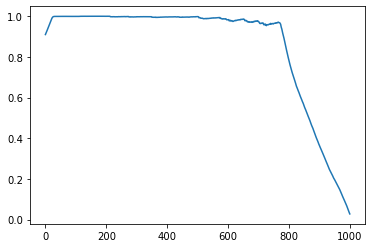

In [74]:
plt.plot(np.mean(train['mask'],axis=0))

In [75]:
early_mask_frac = np.mean(~(train['mask'][:,0:500,:]).astype(bool),axis=(1,2))

In [76]:
early_mask_frac.shape

(70311,)

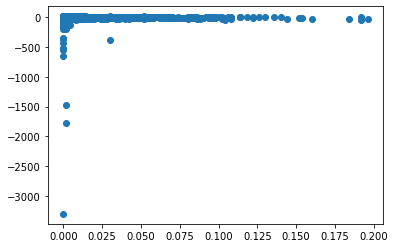

In [77]:
plt.scatter(early_mask_frac, df['logp_corr'])

In [78]:
scipy.stats.pearsonr(early_mask_frac, df['logp_corr'])

(0.01139767589302383, 0.0025088051927141153)

In [79]:
np.where(train['mask'][:,0:500,0]==1)

(array([    0,     0,     0, ..., 70310, 70310, 70310]),
 array([  0,   1,   2, ..., 497, 498, 499]))

In [80]:
train['mask'][:,0:500,0]==1

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True]])

In [81]:
ii = 0
train['mask'][ii,0:500,0]==1

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

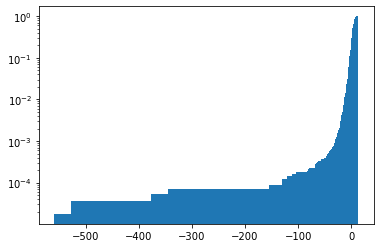

Anomalous Spectra


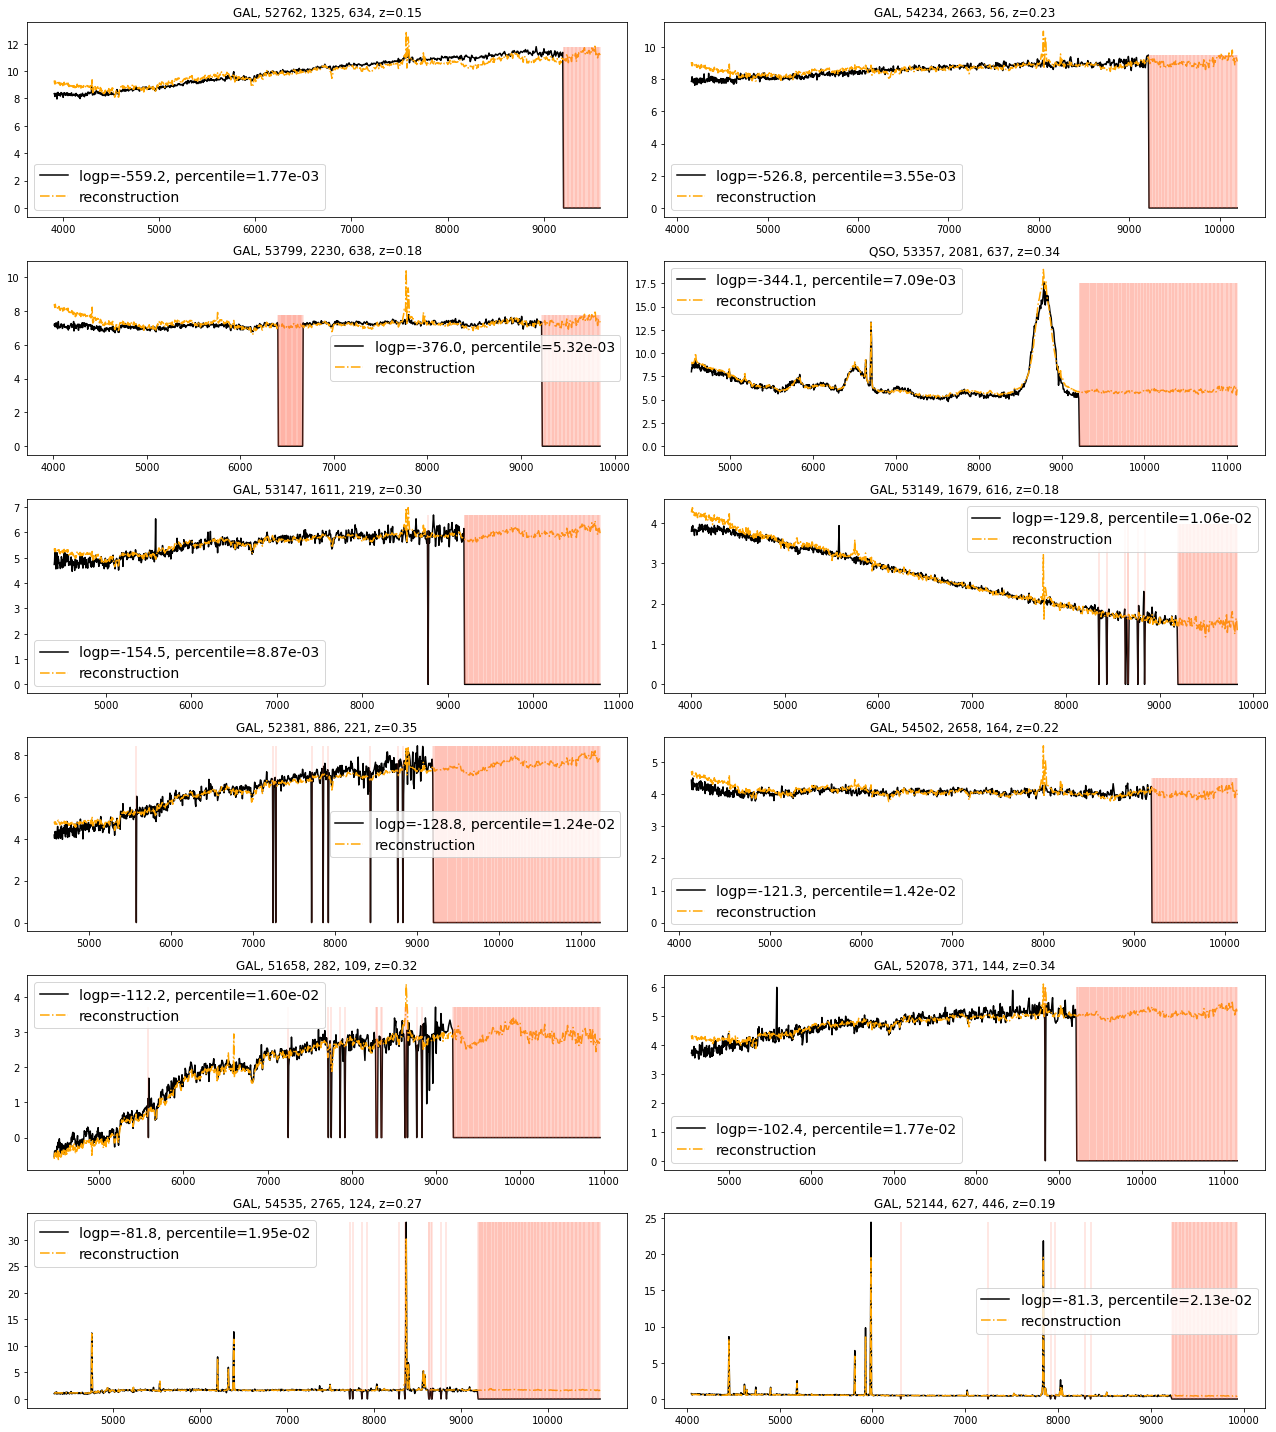

Most Normal Spectra


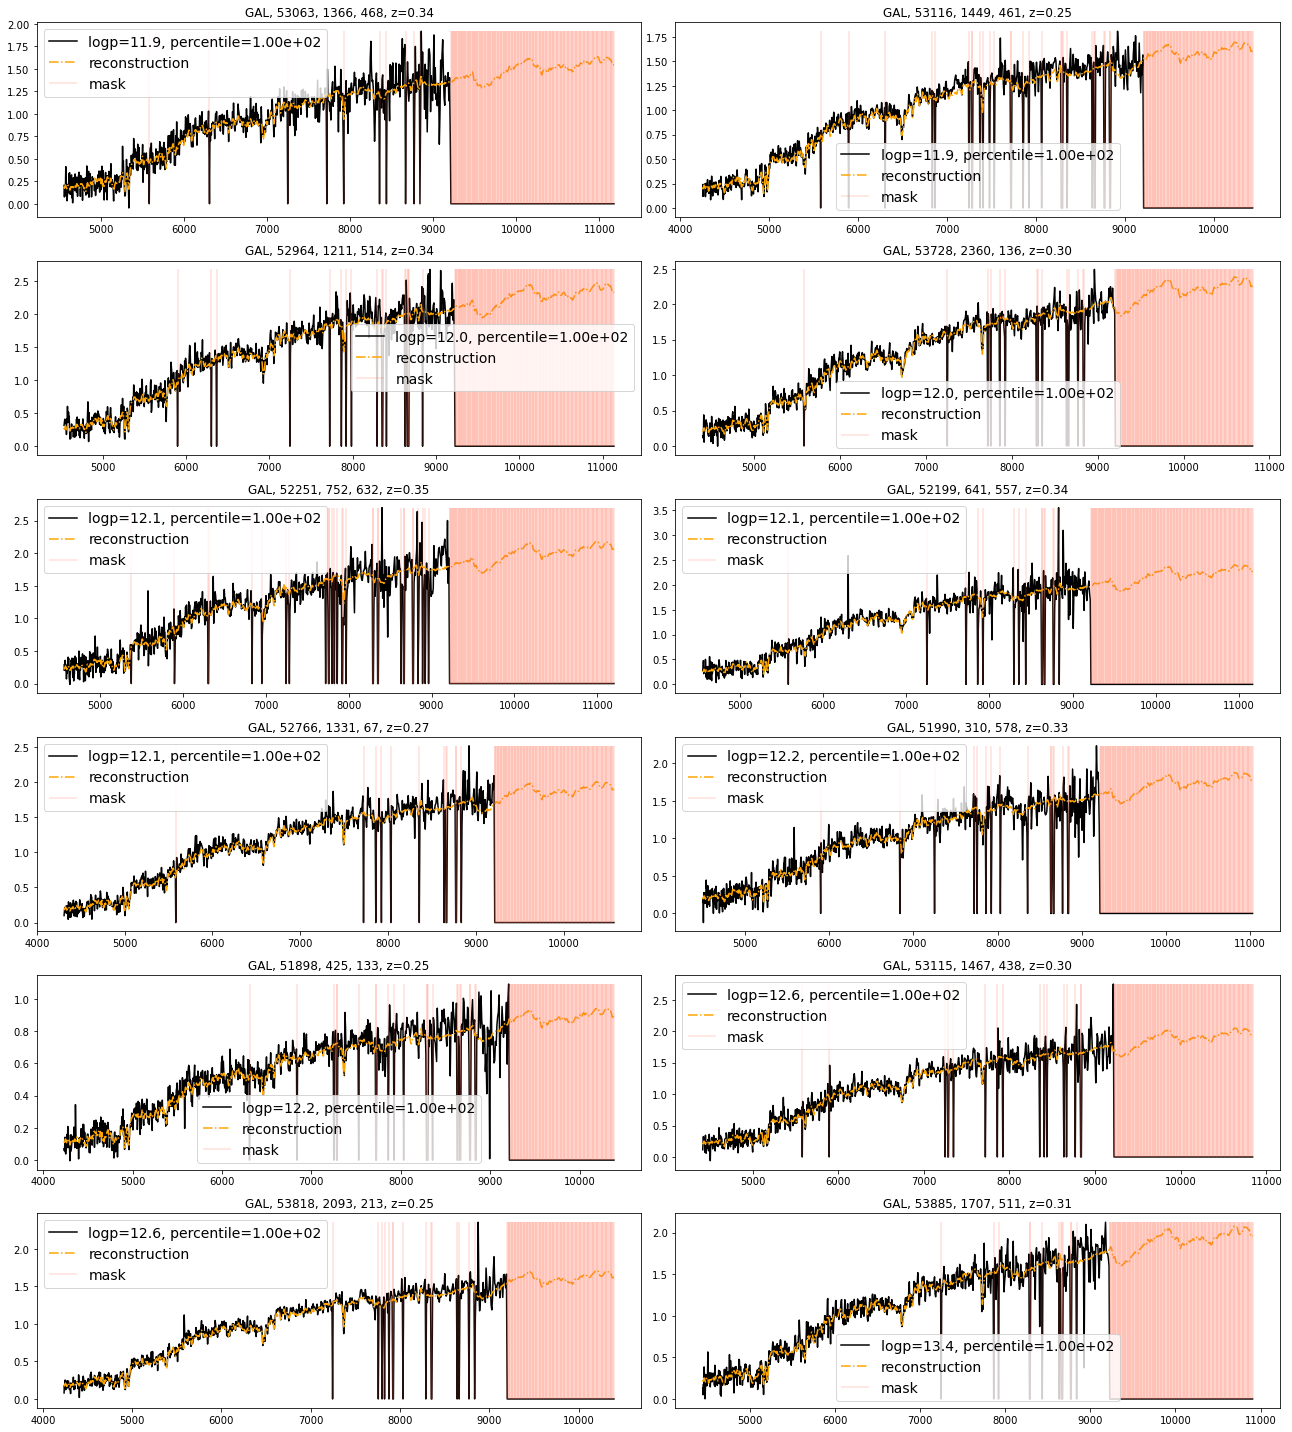

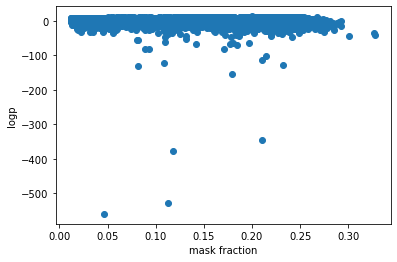

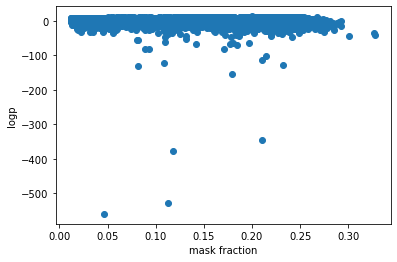

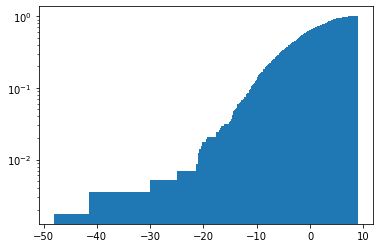

Anomalous Spectra


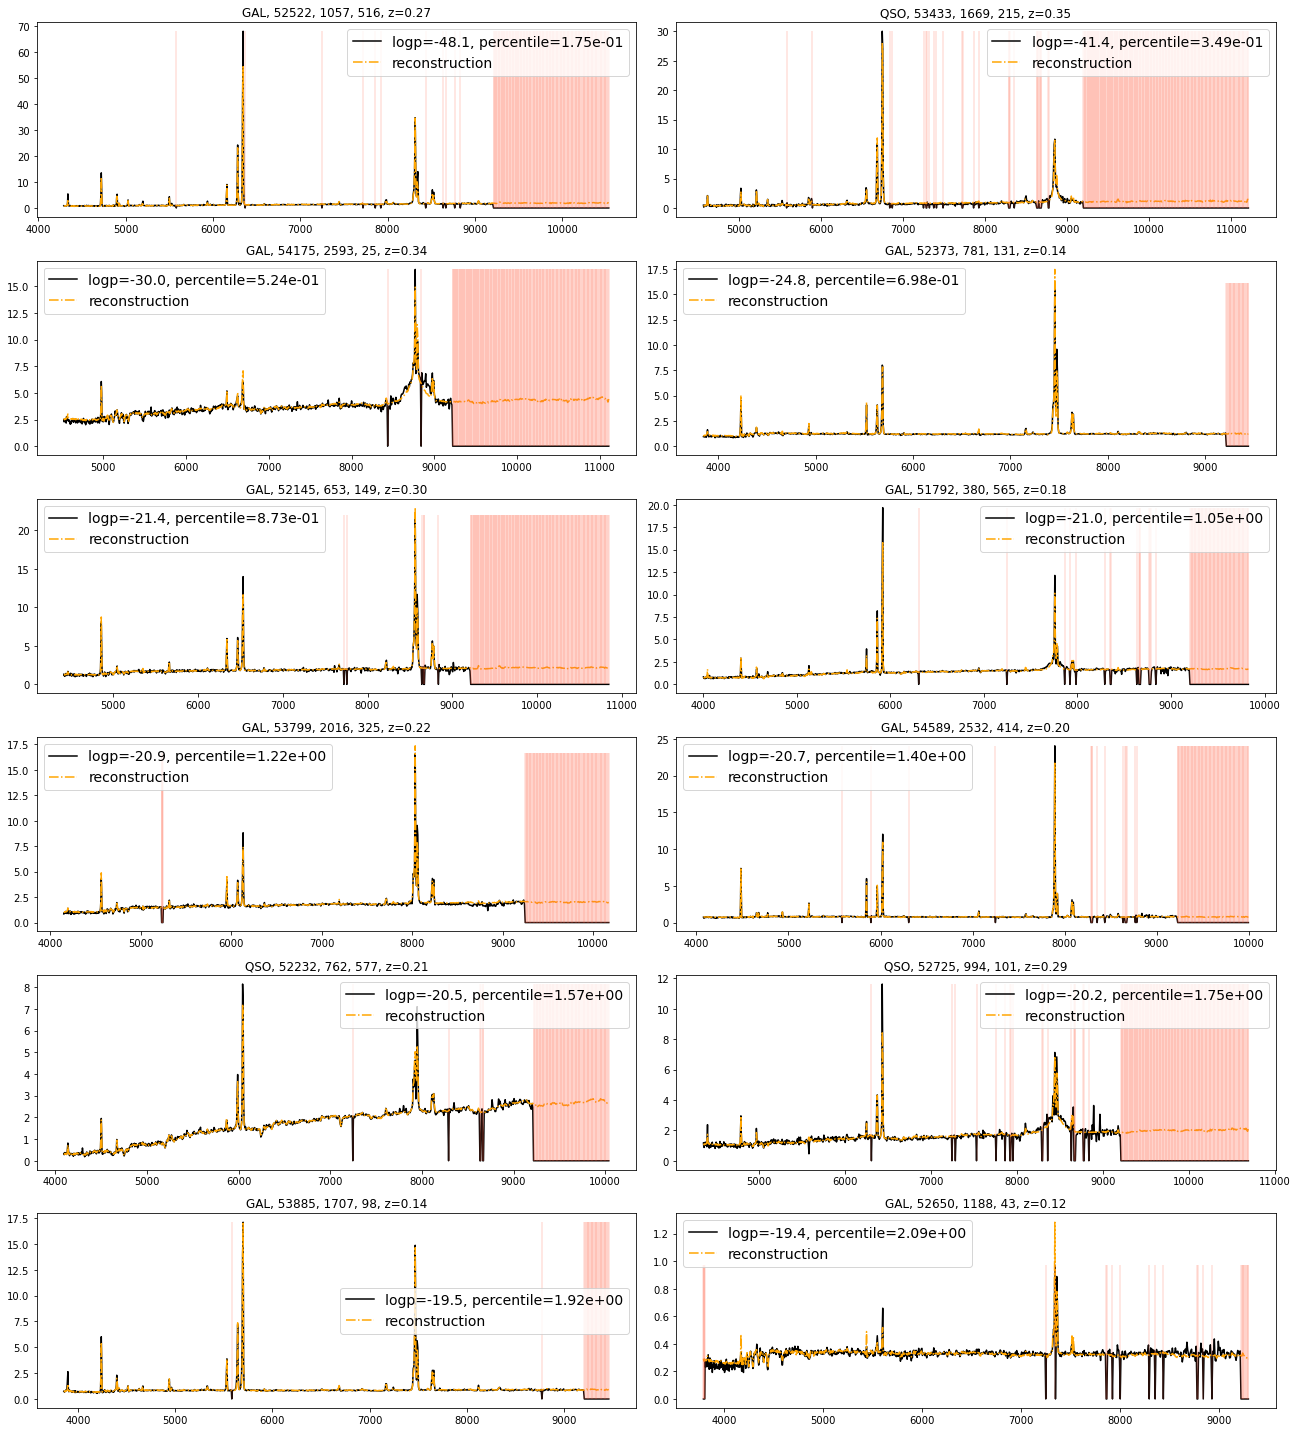

Most Normal Spectra


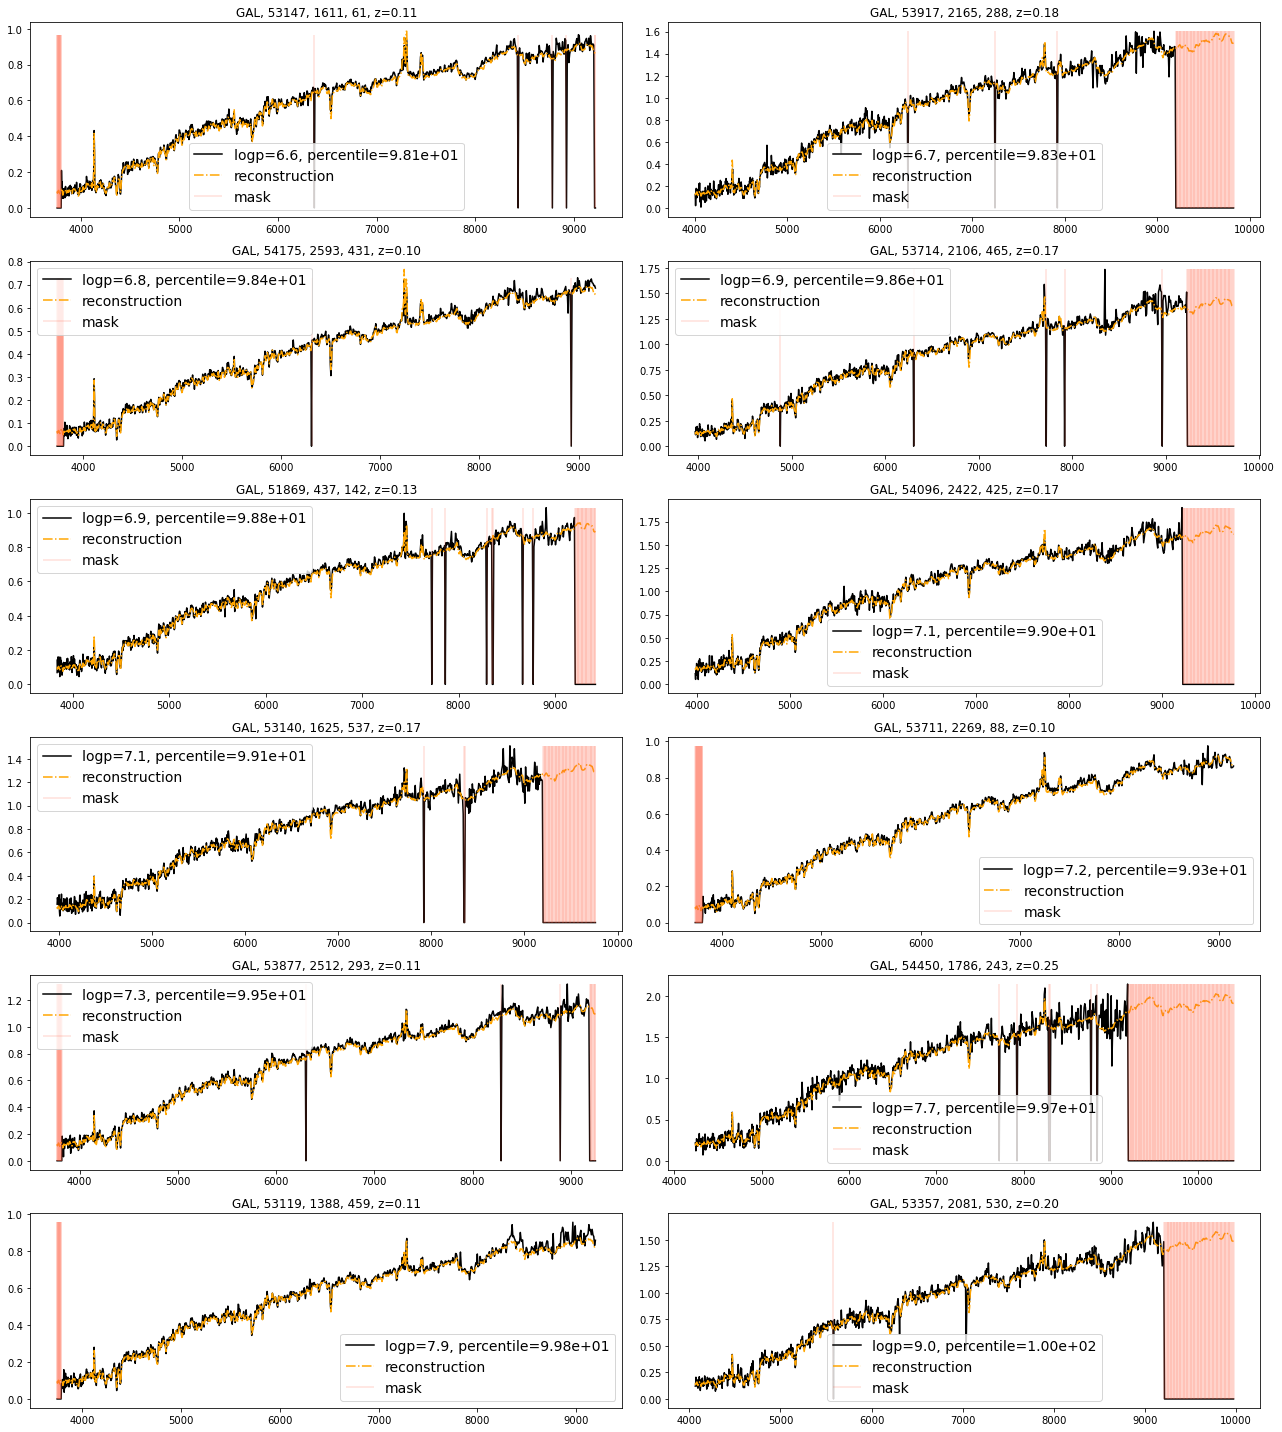

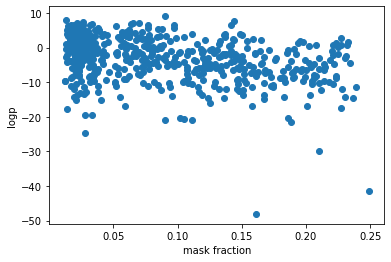

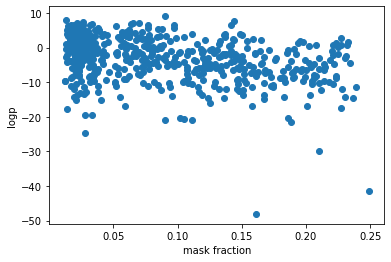

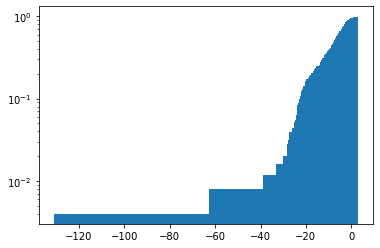

Anomalous Spectra


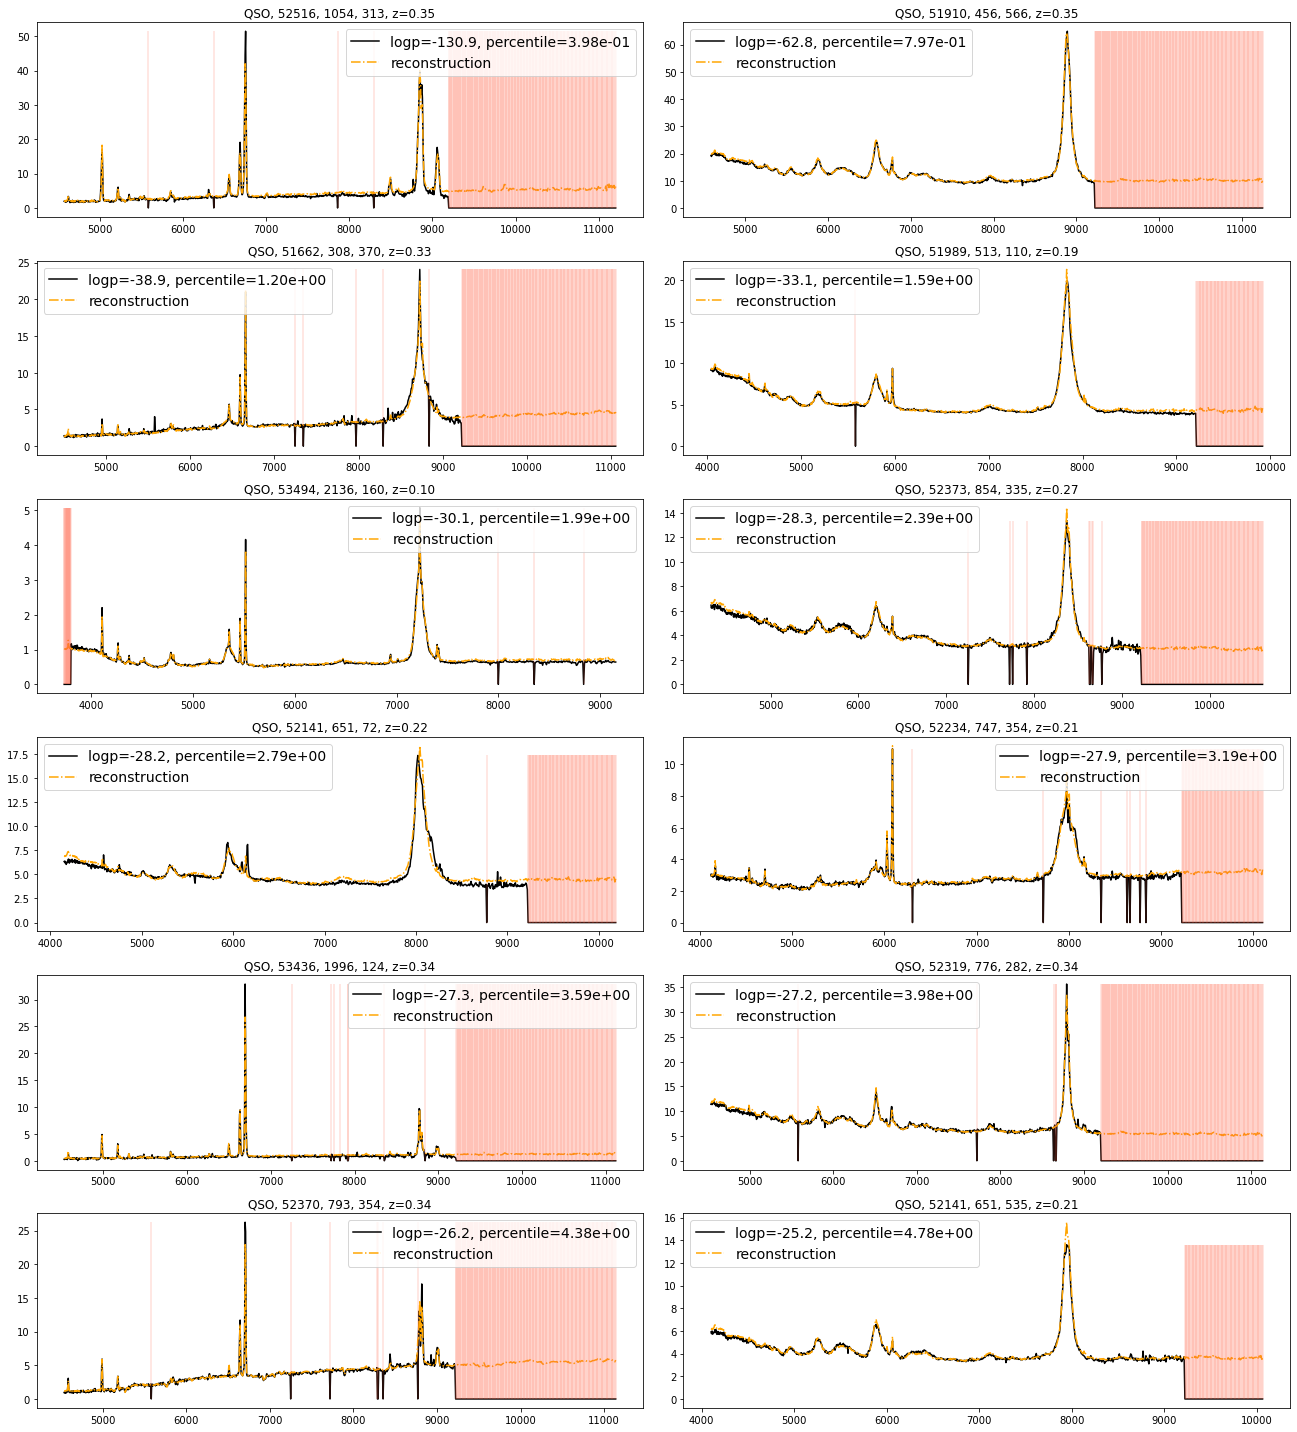

Most Normal Spectra


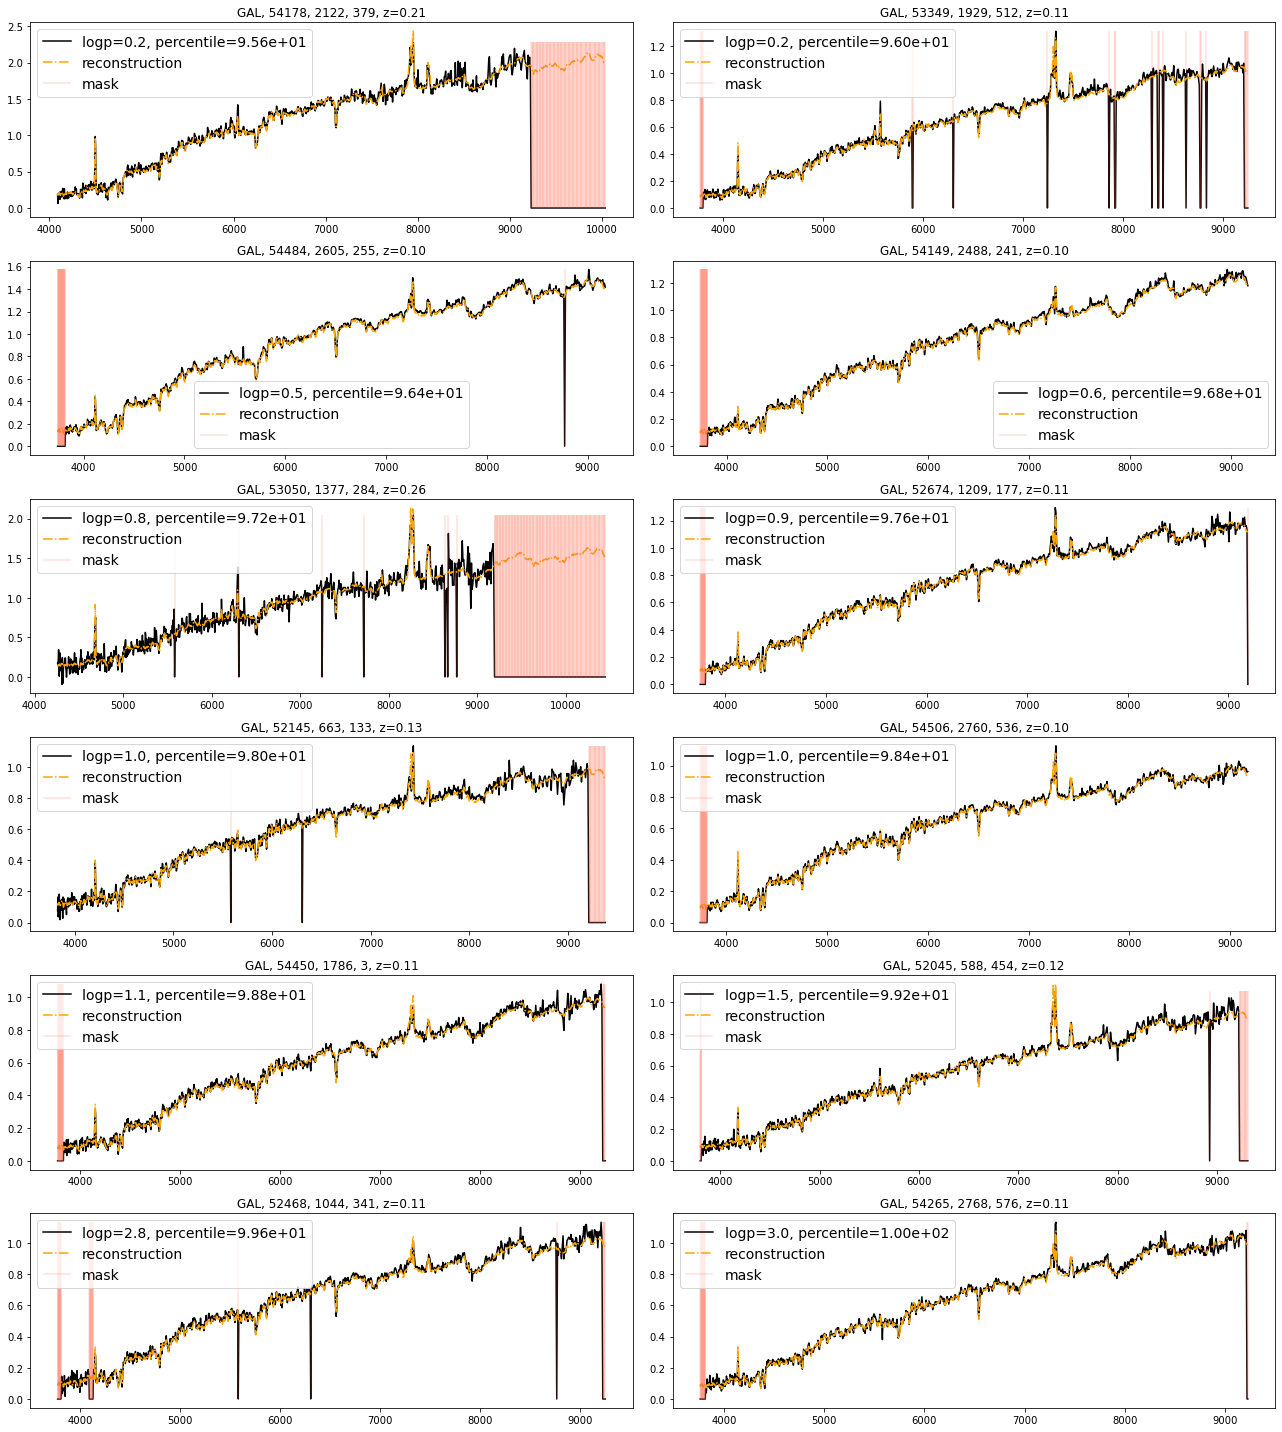

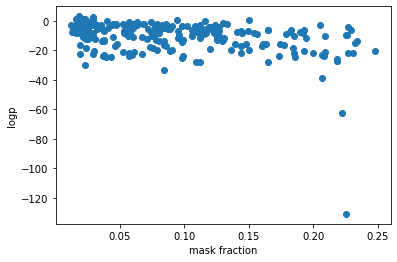

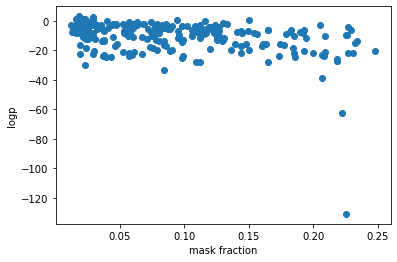

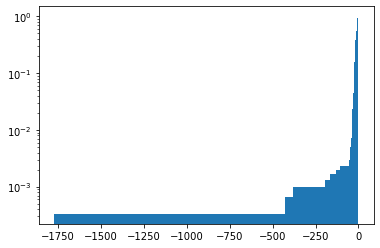

Anomalous Spectra


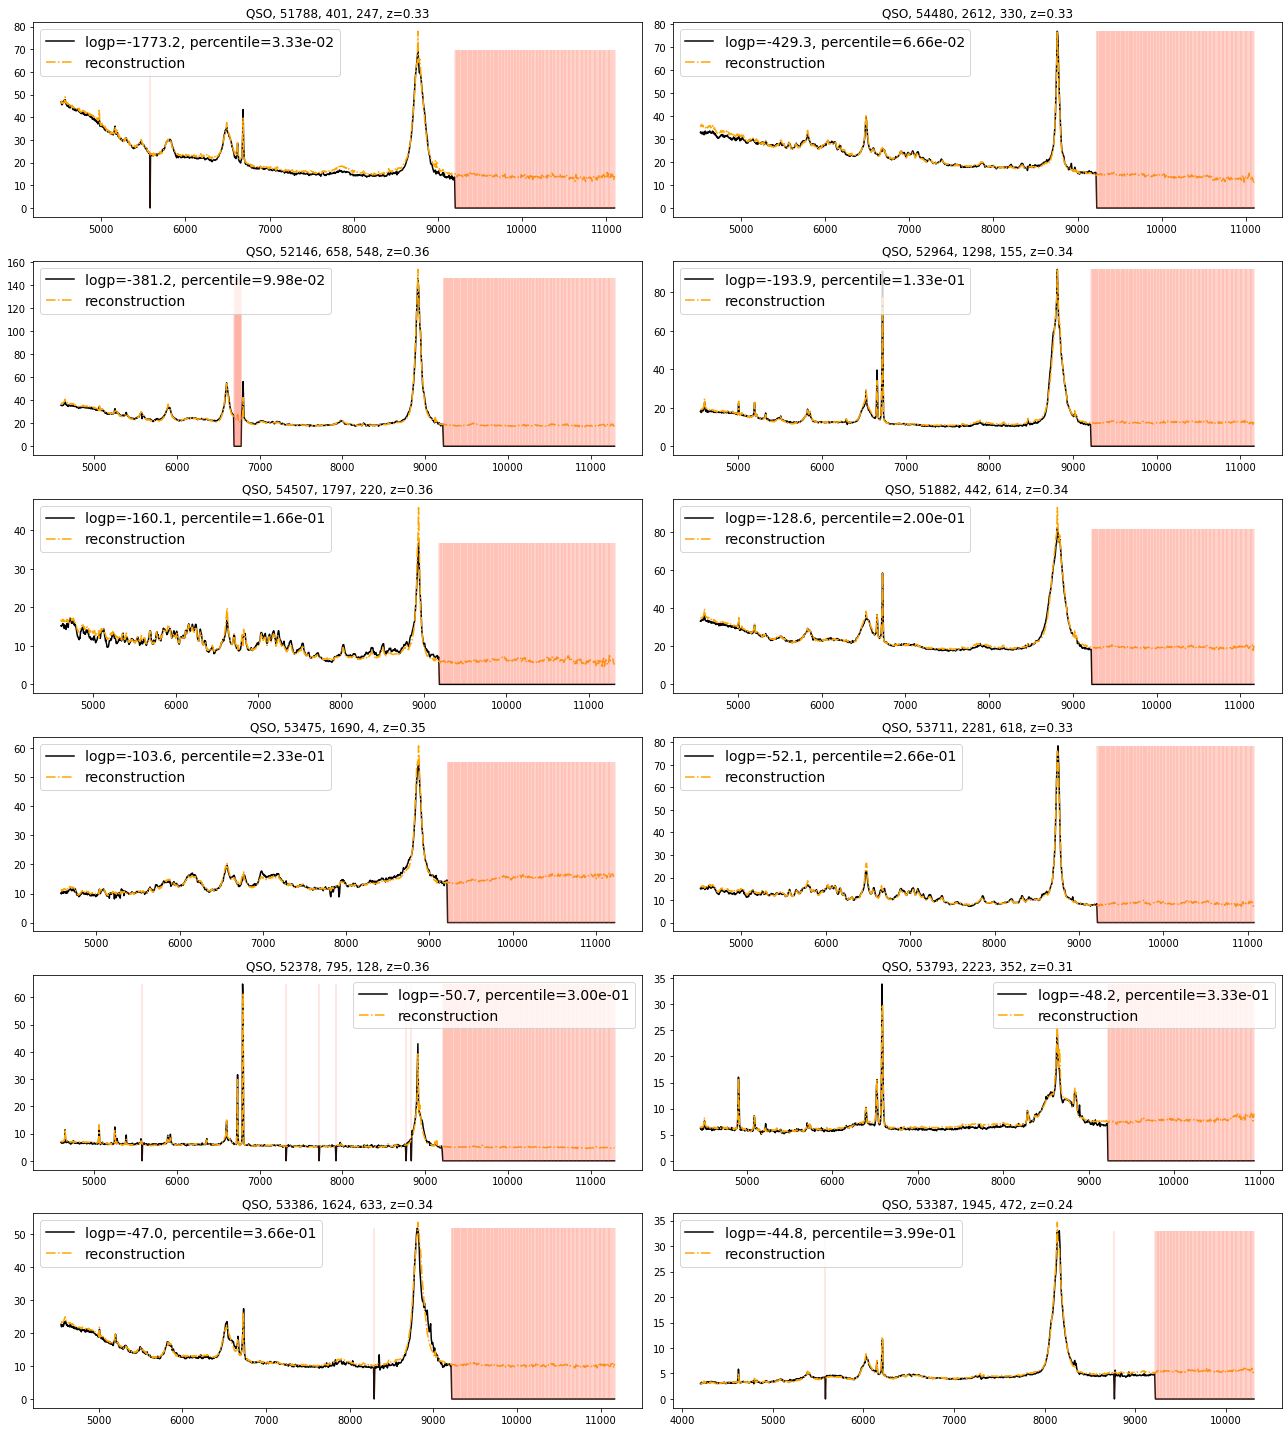

Most Normal Spectra


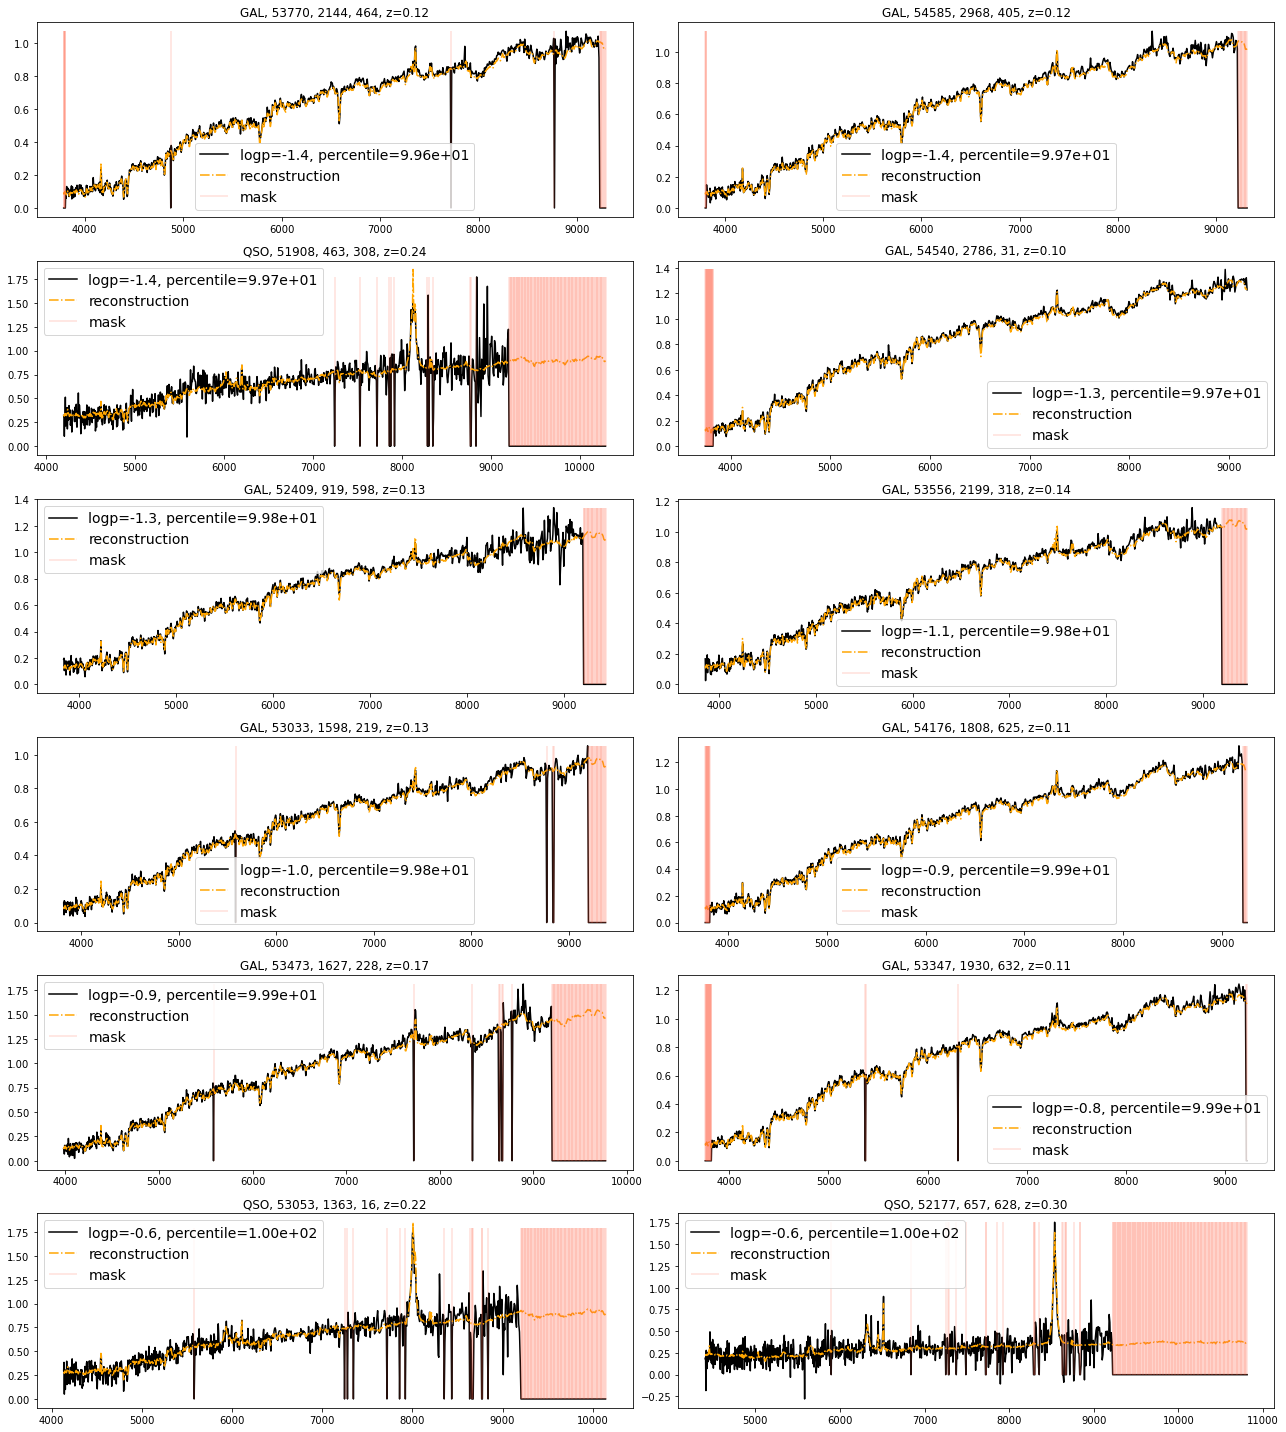

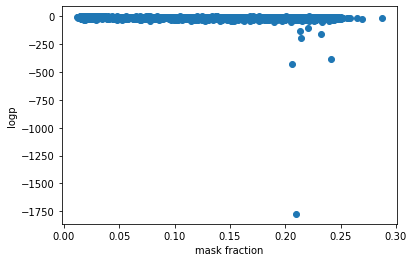

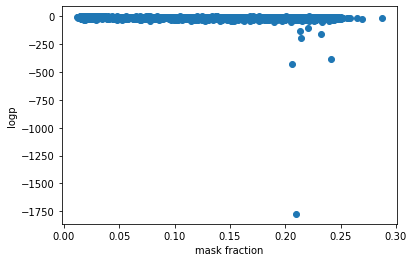

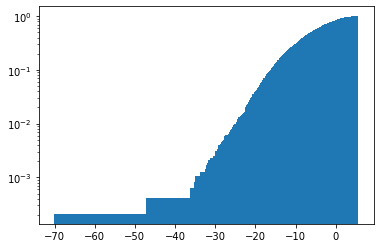

Anomalous Spectra


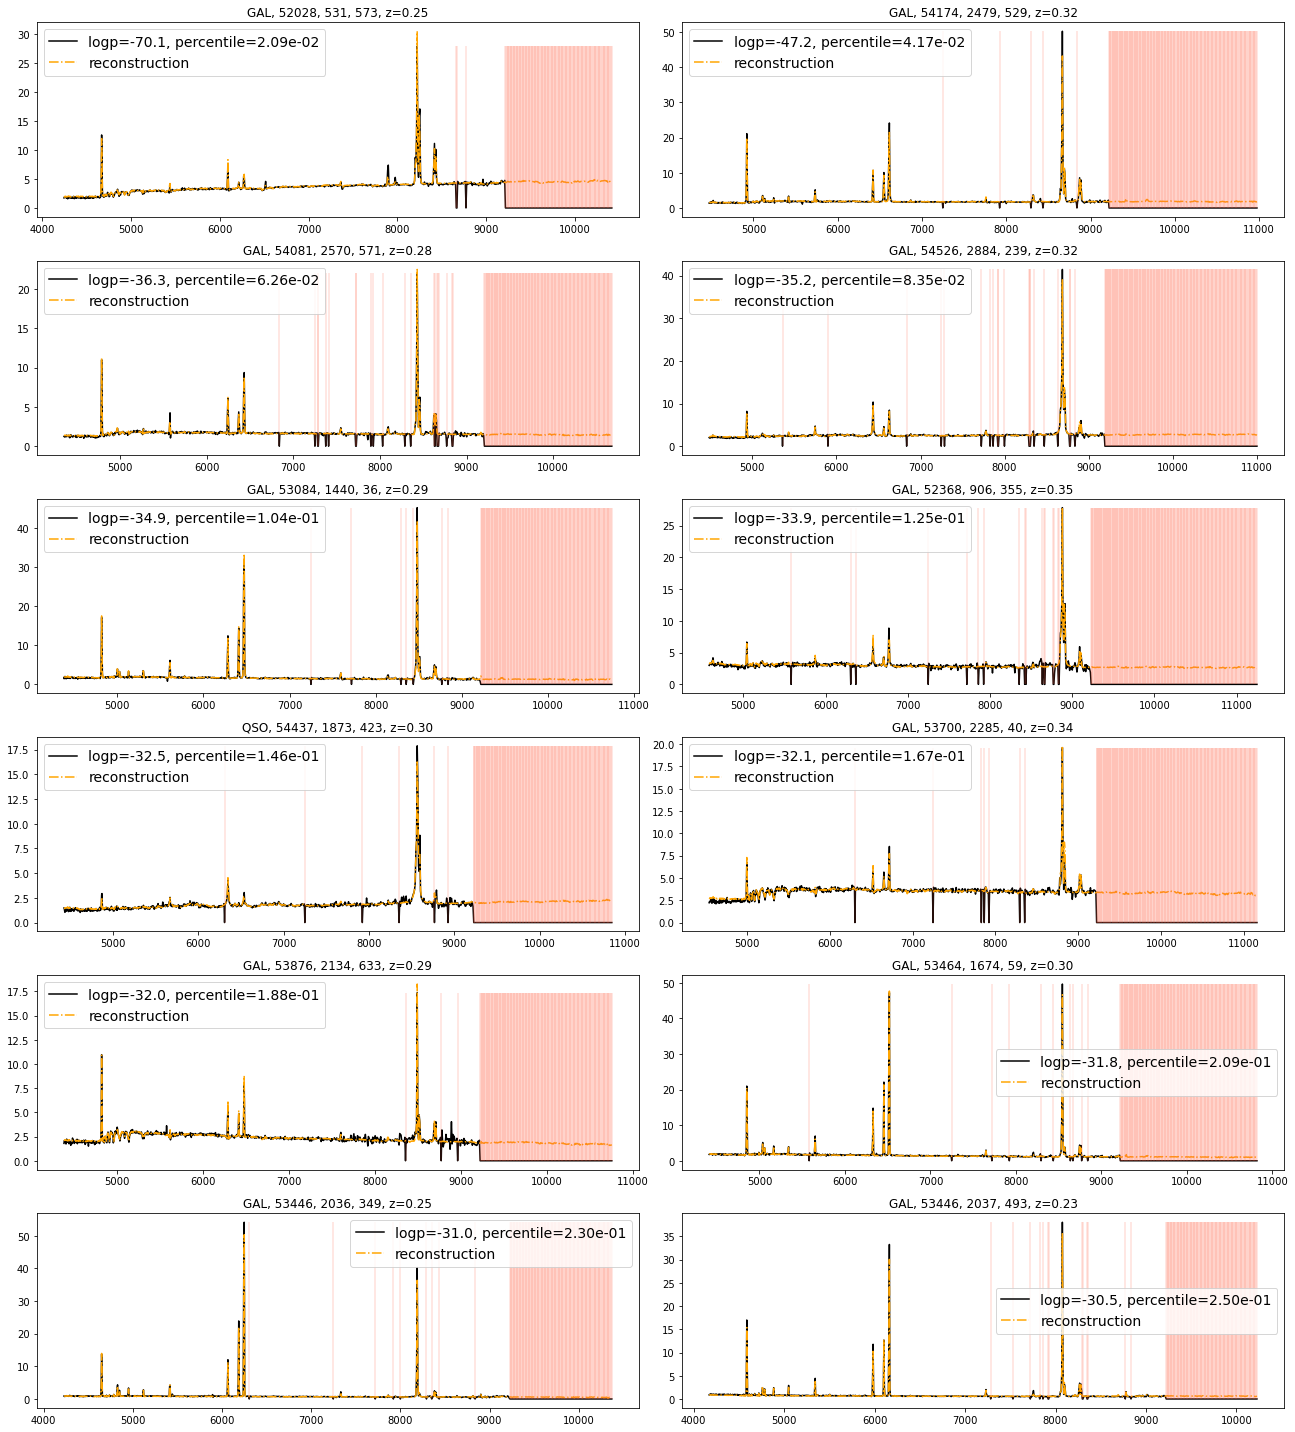

Most Normal Spectra


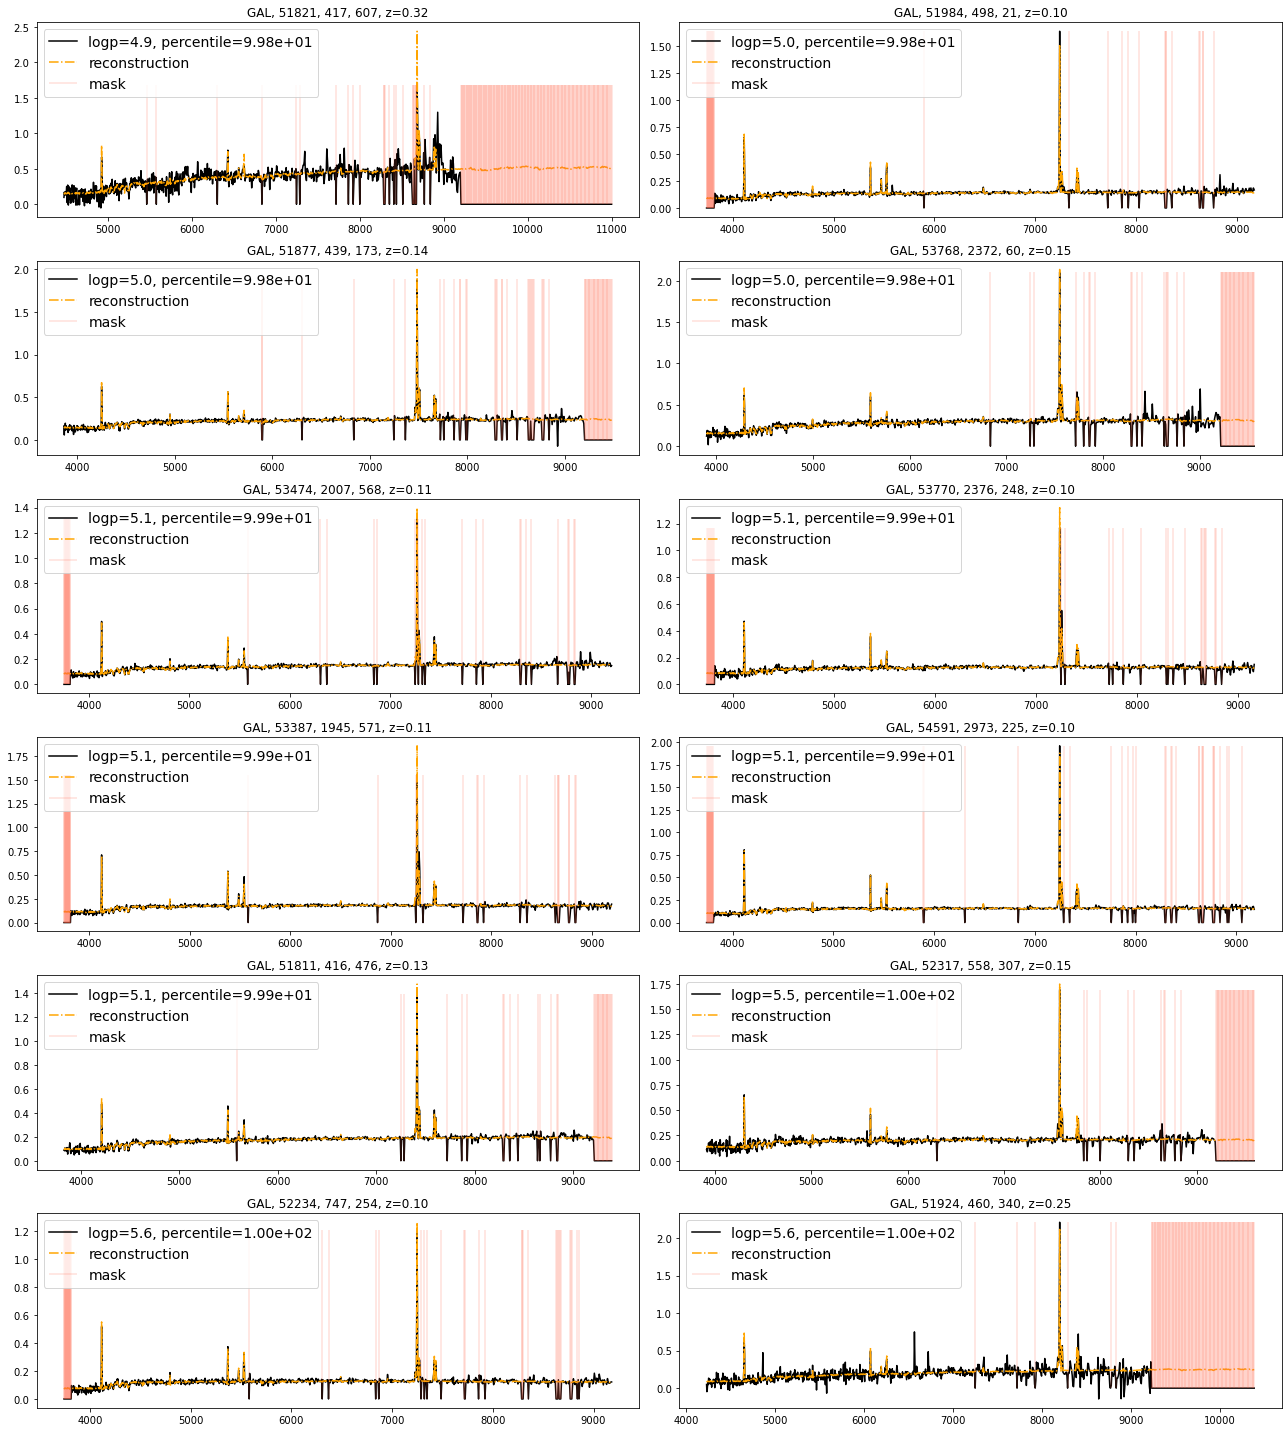

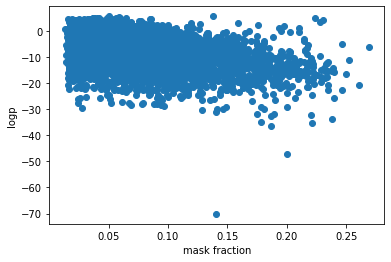

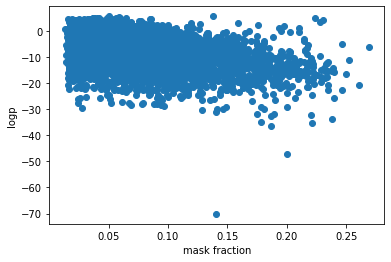

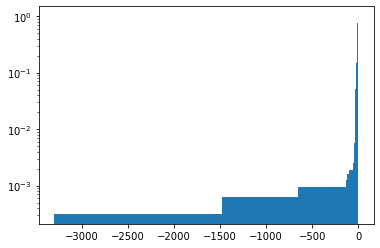

Anomalous Spectra


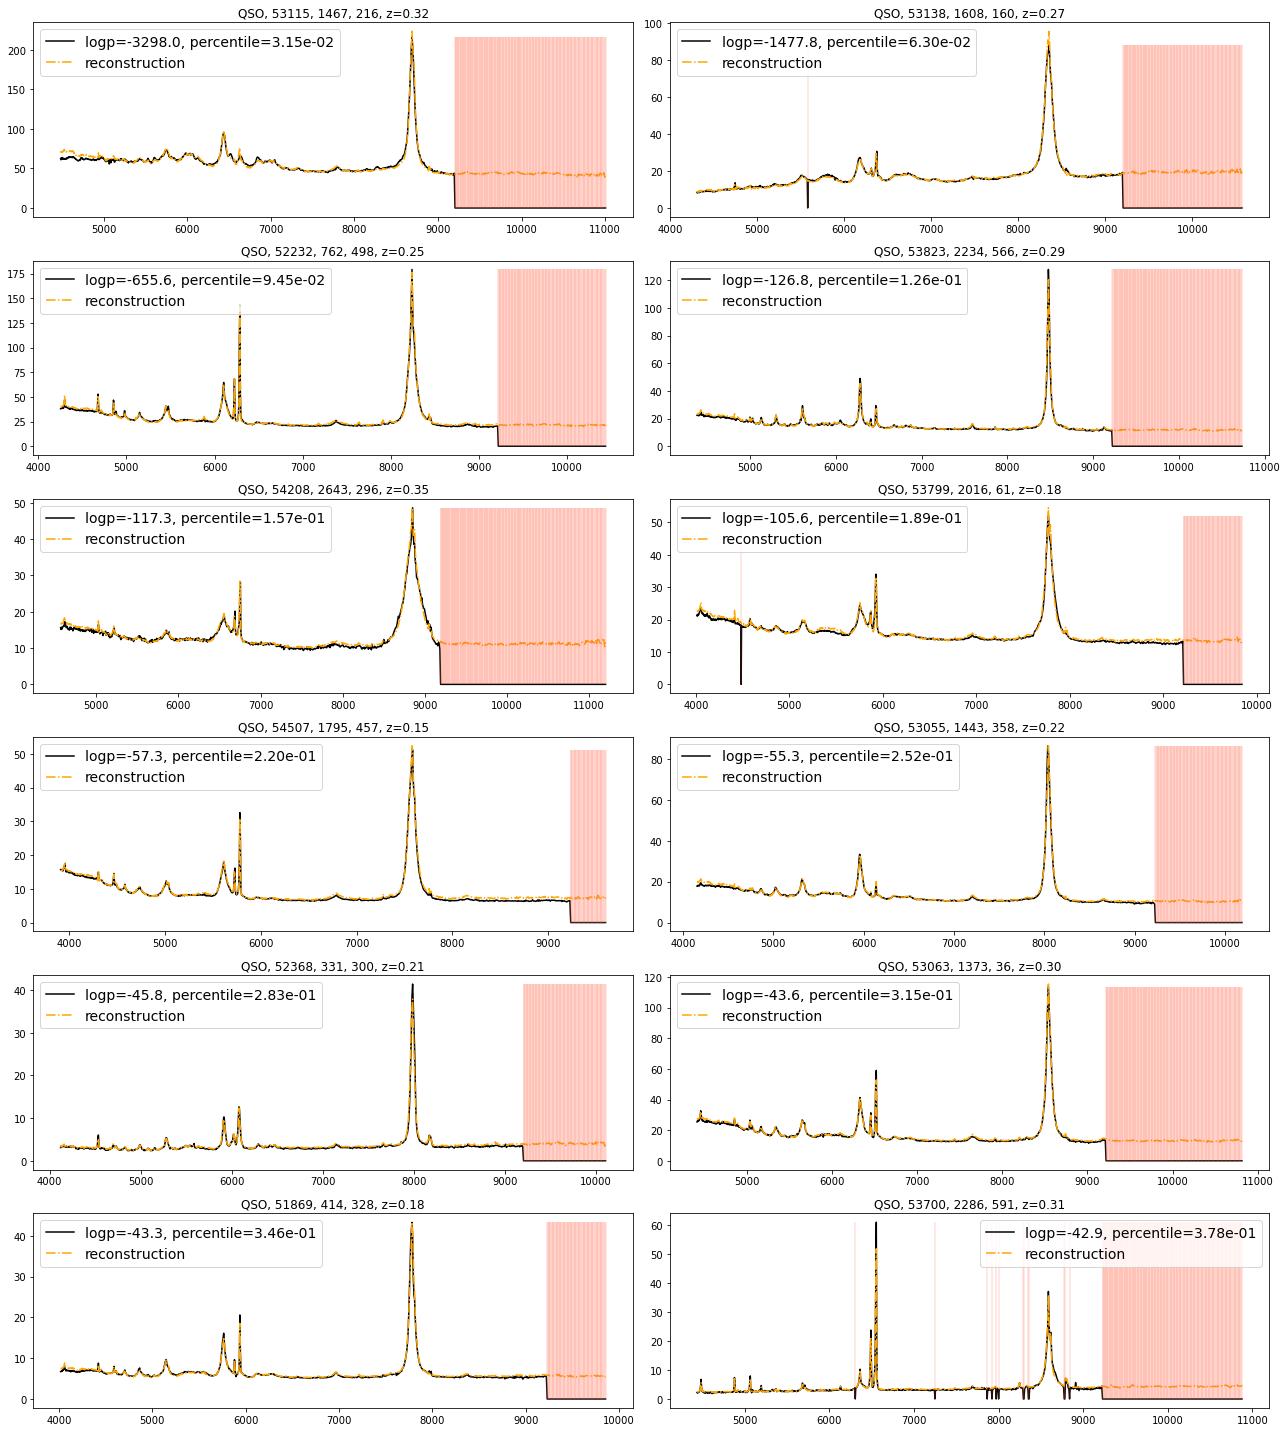

Most Normal Spectra


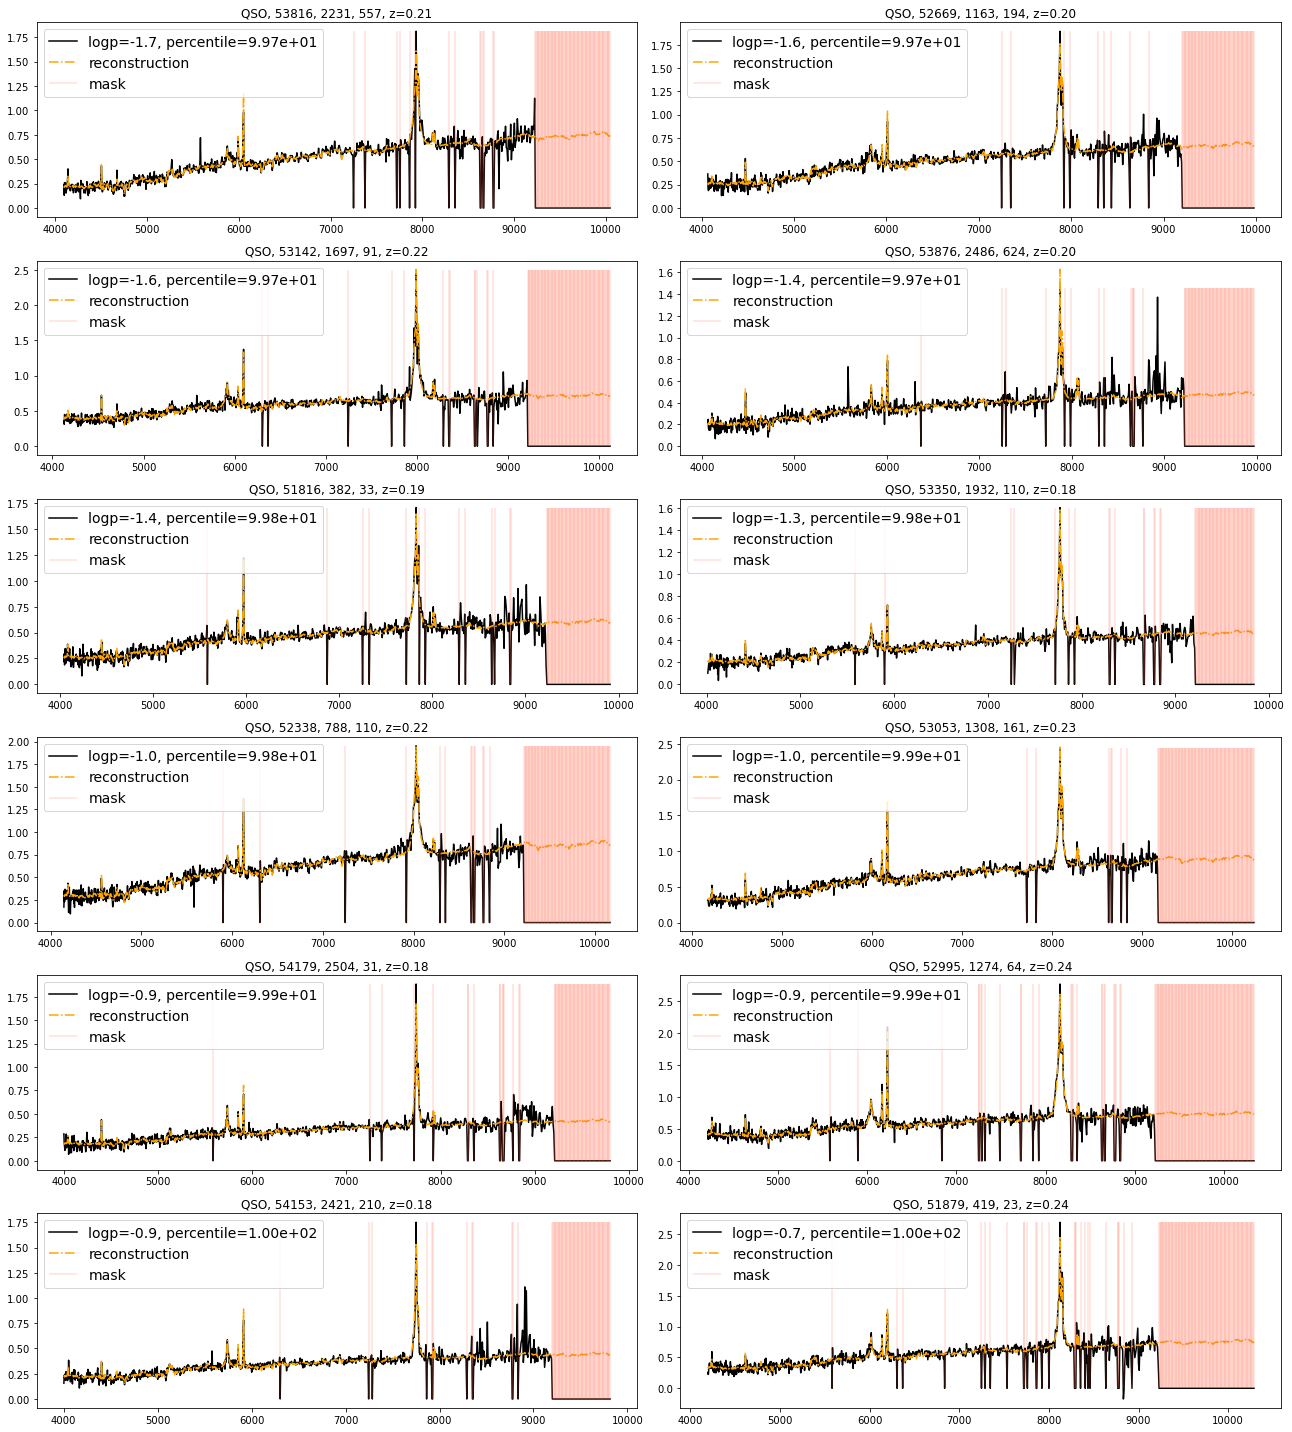

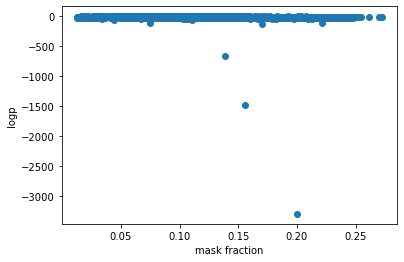

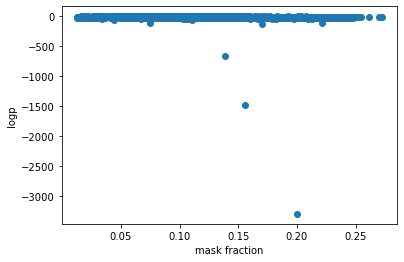

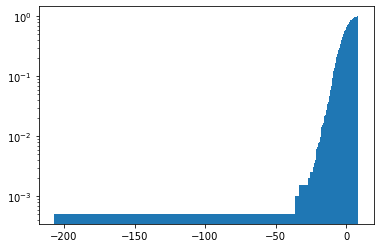

Anomalous Spectra


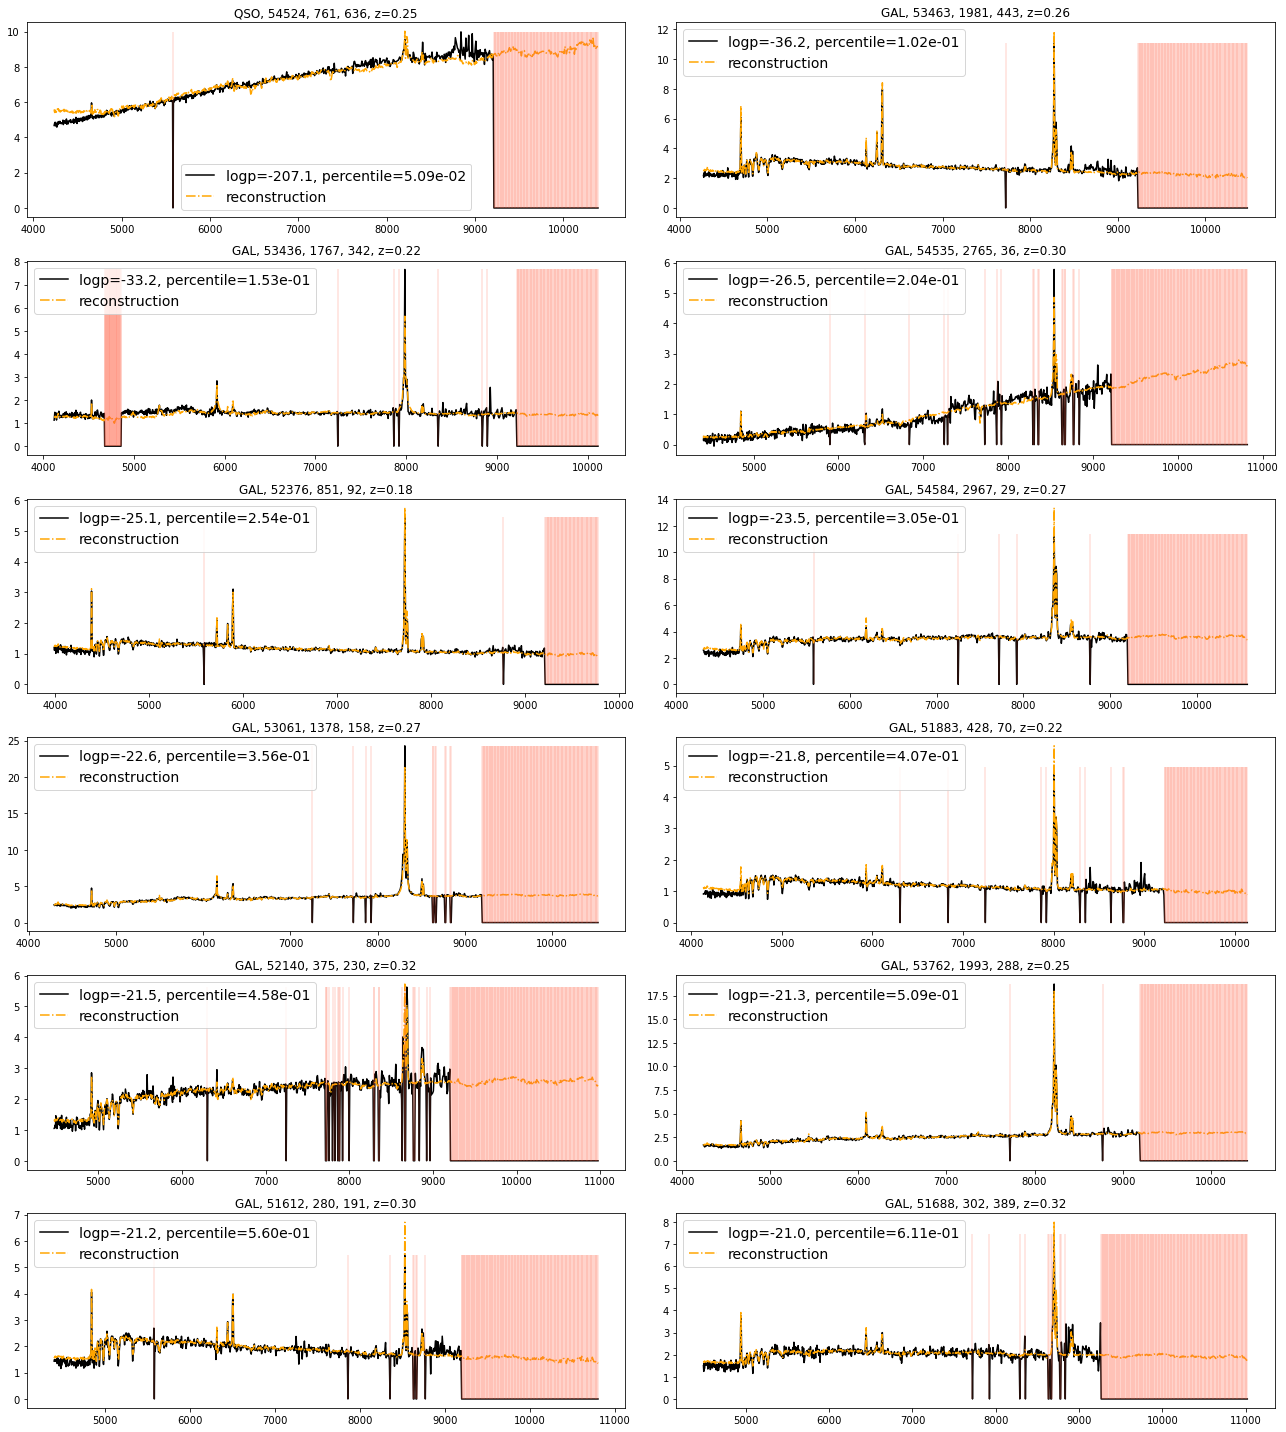

Most Normal Spectra


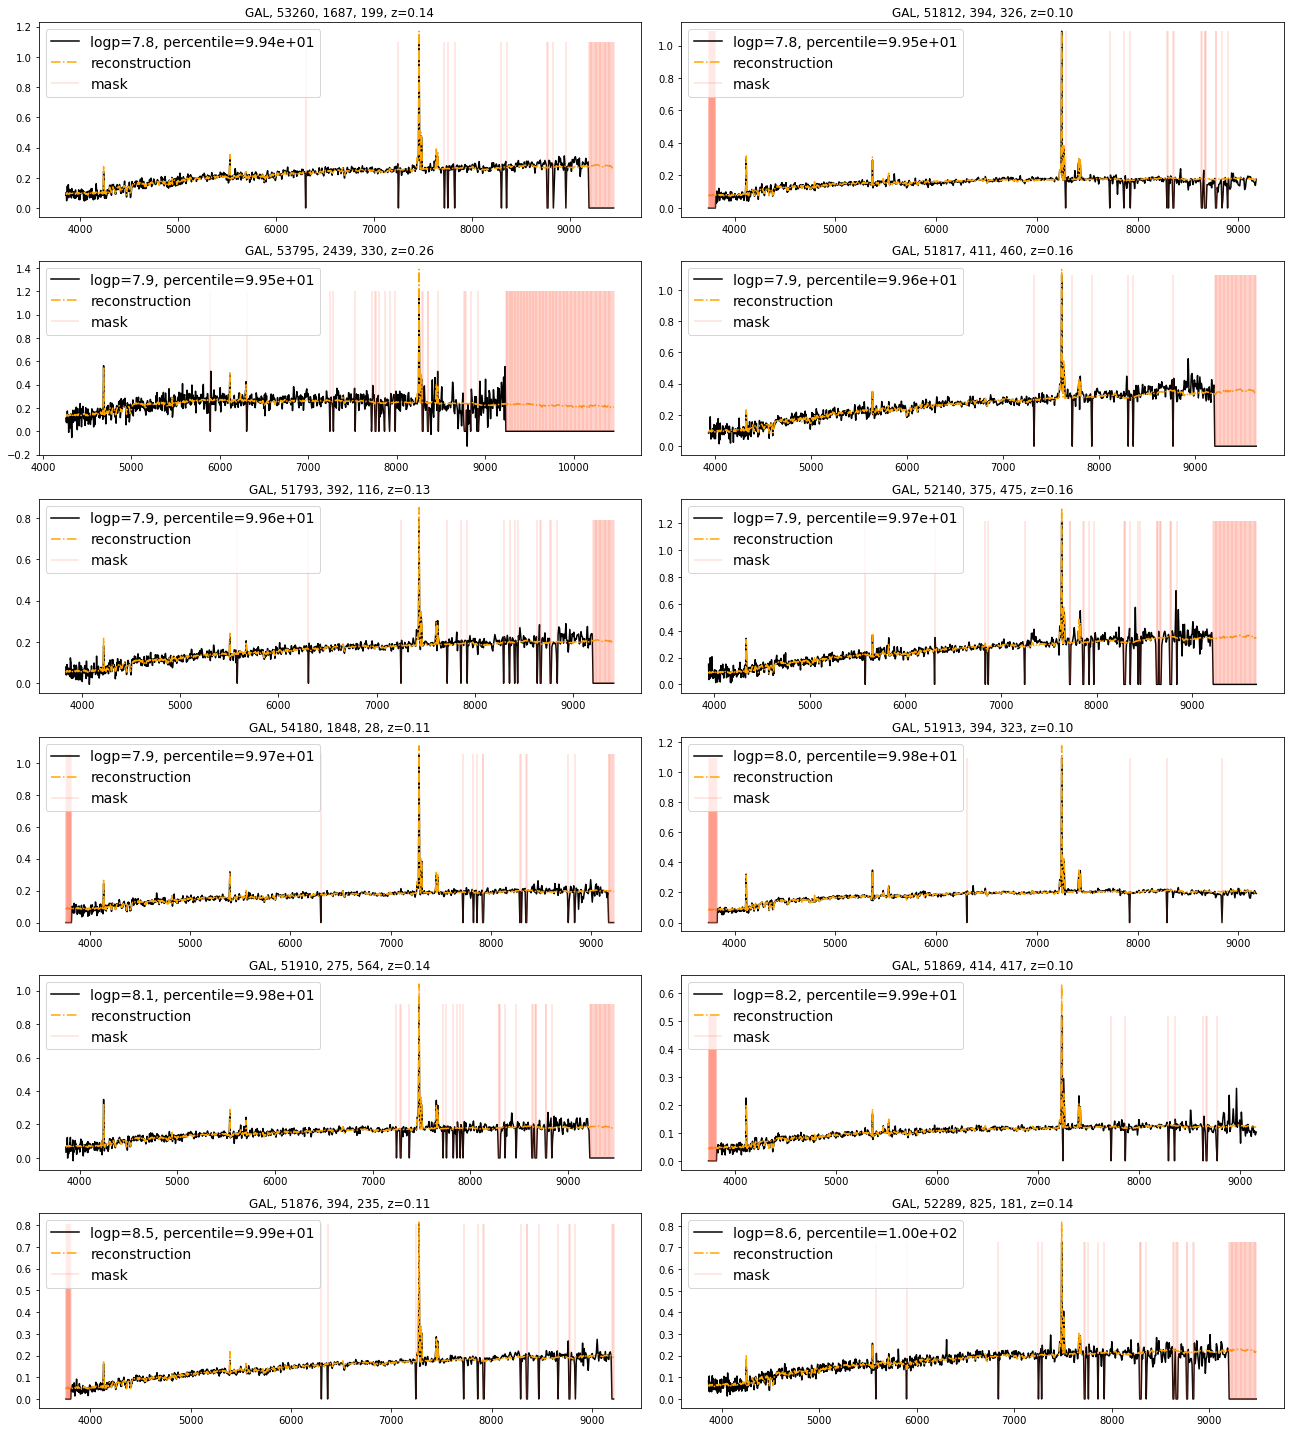

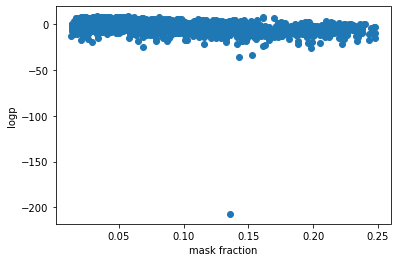

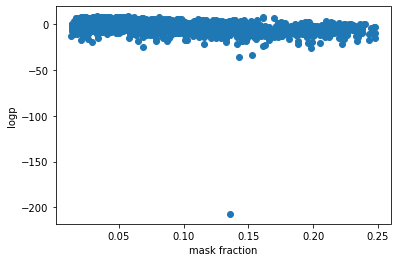

In [82]:
for mm in range(7):
    ind = np.where(train['subclass']==mm)[0]

    mask_fracs      = np.sum(~train['mask'].astype('bool'),axis=1)/1000

    dens            = df['logp_corr'].iloc[ind].to_numpy()

    ind_ood         = np.argsort(dens)
    dens_sorted     = dens[ind_ood]
    train_x_sorted   = train_x[ind][ind_ood].cpu().numpy()


    cum, bins, _      = plt.hist(dens_sorted,bins=500,density=True, cumulative=True, log=True)
    plt.show()

    outliers_decoded  = decoded_train[ind][ind_ood]
    outliers_input    = train['spec'][ind][ind_ood]

    wlmin, wlmax      = (3388,8318)
    fixed_num_bins    = 1000
    wl_range          = (np.log10(wlmin),np.log10(wlmax))
    # new binning 
    new_wl            = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)


    print('Anomalous Spectra')
    fi, ax = plt.subplots(6,2,figsize=(18,20))
    ax = ax.flatten()
    for ii in range(12):
        percentile = scipy.stats.percentileofscore(dens_sorted, dens_sorted[ii], kind='rank')
        ax[ii].set_title('%s, %d, %d, %d, z=%.2f'%(classes[train['class'][ind][ind_ood][ii]], train['MJD'][ind][ind_ood][ii],train['plate'][ind][ind_ood][ii],train['fiber'][ind][ind_ood][ii],train['z'][ind][ind_ood][ii]))
        ax[ii].plot(new_wl[1:]*(train['z'][ind][ind_ood][ii]+1),outliers_input[ii],label='logp=%.1f, percentile=%.2e'%(dens_sorted[ii],percentile), color='black')
        ax[ii].plot(new_wl[1:]*(train['z'][ind][ind_ood][ii]+1),outliers_decoded[ii], label='reconstruction',ls='-.', color='orange')
        ax[ii].vlines( x=new_wl[1:][np.squeeze(~train['mask'][ind][ind_ood][ii].astype(bool))]*(1+train['z'][ind][ind_ood][ii]), ymin=0,ymax=max(train['spec'][ind][ind_ood][ii]), color='tomato',alpha=0.2,zorder=4)

        ax[ii].legend(fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(plotpath,'logp_outliers_class_%s'%(le.inverse_transform([mm])[0]).decode('utf8')), bbox_inches='tight')
    plt.show()

    print('Most Normal Spectra')
    fi, ax = plt.subplots(6,2,figsize=(18,20))
    ax = ax.flatten()
    for nn, ii in enumerate(range(len(ind_ood)-12,len(ind_ood))):
        percentile = scipy.stats.percentileofscore(dens_sorted, dens_sorted[ii], kind='rank')
        ax[nn].set_title('%s, %d, %d, %d, z=%.2f'%(classes[train['class'][ind][ind_ood][ii]], train['MJD'][ind][ind_ood][ii],train['plate'][ind][ind_ood][ii],train['fiber'][ind][ind_ood][ii],train['z'][ind][ind_ood][ii]))
        ax[nn].plot(new_wl[1:]*(train['z'][ind][ind_ood][ii]+1),outliers_input[ii],label='logp=%.1f, percentile=%.2e'%(dens_sorted[ii],percentile), color='black')
        ax[nn].plot(new_wl[1:]*(train['z'][ind][ind_ood][ii]+1),outliers_decoded[ii], label='reconstruction',ls='-.', color='orange')
        ax[nn].vlines( x=new_wl[1:][np.squeeze(~train['mask'][ind][ind_ood][ii].astype(bool))]*(1+train['z'][ind][ind_ood][ii]), ymin=0,ymax=max(train['spec'][ind][ind_ood][ii]), color='tomato',alpha=0.2,zorder=4, label='mask')

        ax[nn].legend(fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(plotpath,'logp_most_common_class_%s'%(le.inverse_transform([mm])[0]).decode('utf8')), bbox_inches='tight')
    plt.show()

    mask_fracs = np.sum(~train['mask'].astype('bool'),axis=1)/1000

    plt.xlabel('mask fraction')
    plt.ylabel('logp')
    plt.scatter(mask_fracs[ind][ind_ood],dens_sorted)
    plt.show()



    plt.xlabel('mask fraction')
    plt.ylabel('logp')
    plt.scatter(mask_fracs[ind][ind_ood],dens_sorted)
    plt.show()

(-0.35872179943242744, 0.0) (-0.23046078529449948, 0.0)


Text(0, 0.5, '-logp')

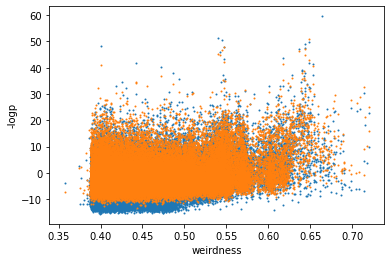

In [83]:
df_extern = pd.read_csv('./external_data/Baronetal_weirdness.csv')

df.columns, df_extern.columns

df.rename(columns={'MJD':' mjd', 'fiber':' fiber'}, inplace=True)

df_overlap = df_extern.merge(df,how='inner',on=['plate',' mjd',' fiber'])

print(scipy.stats.pearsonr(df_overlap['logp'],df_overlap[' weirdness']), scipy.stats.pearsonr(df_overlap['logp_corr'],df_overlap[' weirdness']))

plt.scatter(df_overlap[' weirdness'][df_overlap['logp']>-60],-df_overlap['logp'][df_overlap['logp']>-60],s=1)
plt.scatter(df_overlap[' weirdness'][df_overlap['logp_corr']>-60],-df_overlap['logp_corr'][df_overlap['logp_corr']>-60],s=1)
plt.xlabel('weirdness')
plt.ylabel('-logp')

In [84]:
scipy.stats.pearsonr(df_overlap[' weirdness'],df_overlap['mask_fracs'])

(0.3368890086135672, 0.0)

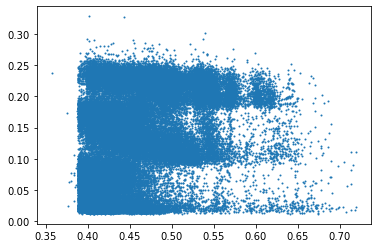

In [85]:
plt.scatter(df_overlap[' weirdness'],df_overlap['mask_fracs'],s=1)